In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import copy
from PIL import Image

In [ ]:
# Paths
train_dir = "fish_dataset/train"
test_dir = "fish_dataset/test"
MODEL_DIR = "Models" 

# Parameters
IMG_SIZE_CNN = 128
IMG_SIZE_PRE = 224
IMG_SIZE_INCEP = 299
BATCH_SIZE = 32
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class-specific augmentation wrapper
class ClassSpecificAugment(torch.utils.data.Dataset):
    def __init__(self, dataset, target_class_name, transform, normal_transform):
        self.dataset = dataset
        self.target_class_idx = dataset.class_to_idx[target_class_name]
        self.transform = transform
        self.normal_transform = normal_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]
        img = Image.open(img_path).convert("RGB")

        if label == self.target_class_idx:
            img = self.transform(img)  # augment bass more heavily
        else:
            img = self.normal_transform(img)
        return img, label

# Transforms
# Heavy augmentation for bass
bass_transform_cnn = transforms.Compose([
    transforms.Resize((IMG_SIZE_CNN, IMG_SIZE_CNN)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(IMG_SIZE_CNN, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

bass_transform_pre = transforms.Compose([
    transforms.Resize((IMG_SIZE_PRE, IMG_SIZE_PRE)),
    transforms.RandomRotation(40),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(IMG_SIZE_PRE, scale=(0.7, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# InceptionV3-specific augmentation
transform_train_incep = transforms.Compose([
    transforms.Resize((IMG_SIZE_INCEP, IMG_SIZE_INCEP)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test_incep = transforms.Compose([
    transforms.Resize((IMG_SIZE_INCEP, IMG_SIZE_INCEP)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Normal transform for other classes
normal_transform_cnn = transforms.Compose([
    transforms.Resize((IMG_SIZE_CNN, IMG_SIZE_CNN)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE_CNN, scale=(0.8, 1.0)),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

normal_transform_pre = transforms.Compose([
    transforms.Resize((IMG_SIZE_PRE, IMG_SIZE_PRE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Test transforms (no augmentation)
test_transforms_cnn = transforms.Compose([
    transforms.Resize((IMG_SIZE_CNN, IMG_SIZE_CNN)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms_pre = transforms.Compose([
    transforms.Resize((IMG_SIZE_PRE, IMG_SIZE_PRE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load once to get class names
train_dataset_original = datasets.ImageFolder(train_dir, transform=normal_transform_cnn)
test_dataset_original = datasets.ImageFolder(test_dir, transform=test_transforms_cnn)
class_names = train_dataset_original.classes

# Load datasets with bass augmentation
base_dataset_cnn = datasets.ImageFolder(train_dir)
train_dataset_cnn = ClassSpecificAugment(base_dataset_cnn, "animal fish bass", bass_transform_cnn, normal_transform_cnn)
test_dataset_cnn = datasets.ImageFolder(test_dir, transform=test_transforms_cnn)

base_dataset_pre = datasets.ImageFolder(train_dir)
train_dataset_pre = ClassSpecificAugment(base_dataset_pre, "animal fish bass", bass_transform_pre, normal_transform_pre)
test_dataset_pre = datasets.ImageFolder(test_dir, transform=test_transforms_pre)

# InceptionV3 (no bass-specific aug — uses its own transform)
train_dataset_incep = datasets.ImageFolder(train_dir, transform=transform_train_incep)
test_dataset_incep = datasets.ImageFolder(test_dir, transform=transform_test_incep)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=BATCH_SIZE, shuffle=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False)

train_loader_pre = DataLoader(train_dataset_pre, batch_size=BATCH_SIZE, shuffle=True)
test_loader_pre = DataLoader(test_dataset_pre, batch_size=BATCH_SIZE, shuffle=False)

train_loader_incep = DataLoader(train_dataset_incep, batch_size=BATCH_SIZE, shuffle=True)
test_loader_incep = DataLoader(test_dataset_incep, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, name, epochs=EPOCHS):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []
    best_model_path = os.path.join(MODEL_DIR, f"{name}_best.pkl")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 20)

        # Training
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)

            # ✅ Handle InceptionV3 & models with logits or tuple outputs
            if isinstance(outputs, tuple) or hasattr(outputs, 'logits'):
                outputs = outputs.logits if hasattr(outputs, 'logits') else outputs[0]

            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        # Validation
        model.eval()
        running_loss, running_corrects = 0.0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)

                if isinstance(outputs, tuple) or hasattr(outputs, 'logits'):
                    outputs = outputs.logits if hasattr(outputs, 'logits') else outputs[0]

                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss = running_loss / len(test_loader.dataset)
        val_acc = running_corrects.double() / len(test_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, best_model_path)
            print(f"💾 Best model saved as {best_model_path} (Acc: {best_acc:.4f})")

    model.load_state_dict(best_model_wts)
    print(f"\n{name} Best Accuracy: {best_acc * 100:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot accuracy/loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc_history, label='Train')
    plt.plot(val_acc_history, label='Val')
    plt.title(f'{name} Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train')
    plt.plot(val_loss_history, label='Val')
    plt.title(f'{name} Loss')
    plt.legend()
    plt.show()

In [90]:
# CNN from the scratch
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE_CNN//8) * (IMG_SIZE_CNN//8), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [99]:
# Pretrained models
def build_pretrained(model_func, num_classes):
    model = model_func(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Freeze backbone

    # Special fix for VGG to avoid mat1/mat2 shape mismatch
    if model_func == models.vgg16:
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        return model.to(DEVICE)

    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            in_features = model.classifier[-1].in_features
        else:
            in_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    return model.to(DEVICE)


Epoch 1/30
--------------------
Train Loss: 1.8336 Acc: 0.3534
Val Loss: 1.3345 Acc: 0.6221
💾 Best model saved as SimpleCNN_best.pkl (Acc: 0.6221)

Epoch 2/30
--------------------
Train Loss: 1.3836 Acc: 0.5218
Val Loss: 0.9979 Acc: 0.7316
💾 Best model saved as SimpleCNN_best.pkl (Acc: 0.7316)

Epoch 3/30
--------------------
Train Loss: 1.1260 Acc: 0.6215
Val Loss: 0.7764 Acc: 0.7823
💾 Best model saved as SimpleCNN_best.pkl (Acc: 0.7823)

Epoch 4/30
--------------------
Train Loss: 0.9426 Acc: 0.6813
Val Loss: 0.6408 Acc: 0.7998
💾 Best model saved as SimpleCNN_best.pkl (Acc: 0.7998)

Epoch 5/30
--------------------
Train Loss: 0.8253 Acc: 0.7227
Val Loss: 0.5454 Acc: 0.8511
💾 Best model saved as SimpleCNN_best.pkl (Acc: 0.8511)

Epoch 6/30
--------------------
Train Loss: 0.7374 Acc: 0.7516
Val Loss: 0.4641 Acc: 0.8755
💾 Best model saved as SimpleCNN_best.pkl (Acc: 0.8755)

Epoch 7/30
--------------------
Train Loss: 0.6789 Acc: 0.7672
Val Loss: 0.3832 Acc: 0.9077
💾 Best model saved 

c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

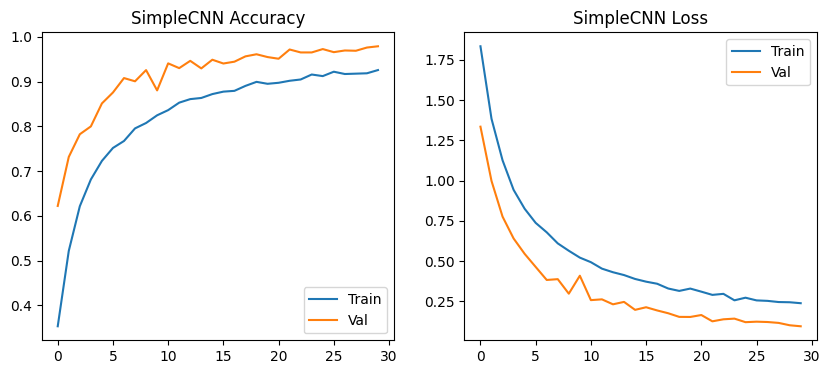

In [92]:
cnn_model = SimpleCNN(num_classes=len(train_dataset_cnn.dataset.classes)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)
train_and_evaluate(cnn_model, train_loader_cnn, test_loader_cnn, criterion, optimizer, "SimpleCNN")

c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/30
--------------------
Train Loss: 1.2360 Acc: 0.6876
Val Loss: 0.6587 Acc: 0.9290
💾 Best model saved as VGG16_best.pkl (Acc: 0.9290)

Epoch 2/30
--------------------
Train Loss: 0.4989 Acc: 0.9123
Val Loss: 0.3869 Acc: 0.9540
💾 Best model saved as VGG16_best.pkl (Acc: 0.9540)

Epoch 3/30
--------------------
Train Loss: 0.3359 Acc: 0.9383
Val Loss: 0.2830 Acc: 0.9603
💾 Best model saved as VGG16_best.pkl (Acc: 0.9603)

Epoch 4/30
--------------------
Train Loss: 0.2554 Acc: 0.9513
Val Loss: 0.2260 Acc: 0.9637
💾 Best model saved as VGG16_best.pkl (Acc: 0.9637)

Epoch 5/30
--------------------
Train Loss: 0.2132 Acc: 0.9592
Val Loss: 0.1876 Acc: 0.9678
💾 Best model saved as VGG16_best.pkl (Acc: 0.9678)

Epoch 6/30
--------------------
Train Loss: 0.1823 Acc: 0.9614
Val Loss: 0.1634 Acc: 0.9706
💾 Best model saved as VGG16_best.pkl (Acc: 0.9706)

Epoch 7/30
--------------------
Train Loss: 0.1596 Acc: 0.9664
Val Loss: 0.1444 Acc: 0.9737
💾 Best model saved as VGG16_best.pkl (Acc: 

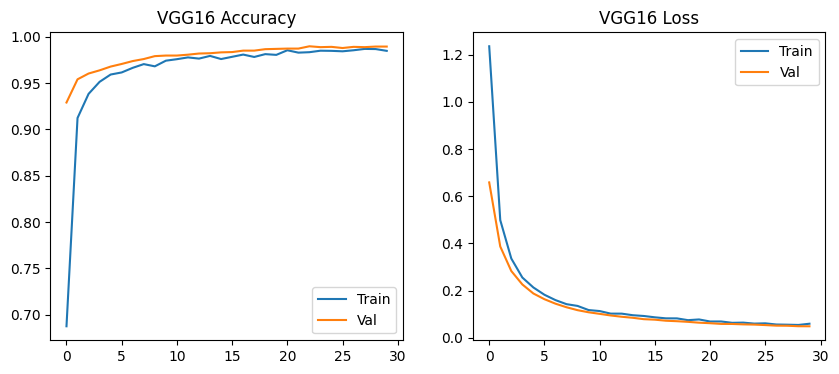

In [93]:
model_vgg16 = build_pretrained(models.vgg16, num_classes=len(train_dataset_pre.dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg16.parameters(), lr=1e-4)
train_and_evaluate(model_vgg16, train_loader_pre, test_loader_pre, criterion, optimizer, "VGG16")

c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/30
--------------------
Train Loss: 1.7124 Acc: 0.5147
Val Loss: 1.0617 Acc: 0.8987
💾 Best model saved as ResNet50_best.pkl (Acc: 0.8987)

Epoch 2/30
--------------------
Train Loss: 0.9129 Acc: 0.8228
Val Loss: 0.5671 Acc: 0.9521
💾 Best model saved as ResNet50_best.pkl (Acc: 0.9521)

Epoch 3/30
--------------------
Train Loss: 0.6060 Acc: 0.8808
Val Loss: 0.3844 Acc: 0.9622
💾 Best model saved as ResNet50_best.pkl (Acc: 0.9622)

Epoch 4/30
--------------------
Train Loss: 0.4576 Acc: 0.9086
Val Loss: 0.2672 Acc: 0.9712
💾 Best model saved as ResNet50_best.pkl (Acc: 0.9712)

Epoch 5/30
--------------------
Train Loss: 0.3531 Acc: 0.9304
Val Loss: 0.2056 Acc: 0.9775
💾 Best model saved as ResNet50_best.pkl (Acc: 0.9775)

Epoch 6/30
--------------------
Train Loss: 0.3124 Acc: 0.9330
Val Loss: 0.1680 Acc: 0.9806
💾 Best model saved as ResNet50_best.pkl (Acc: 0.9806)

Epoch 7/30
--------------------
Train Loss: 0.2569 Acc: 0.9478
Val Loss: 0.1394 Acc: 0.9784

Epoch 8/30
-------------

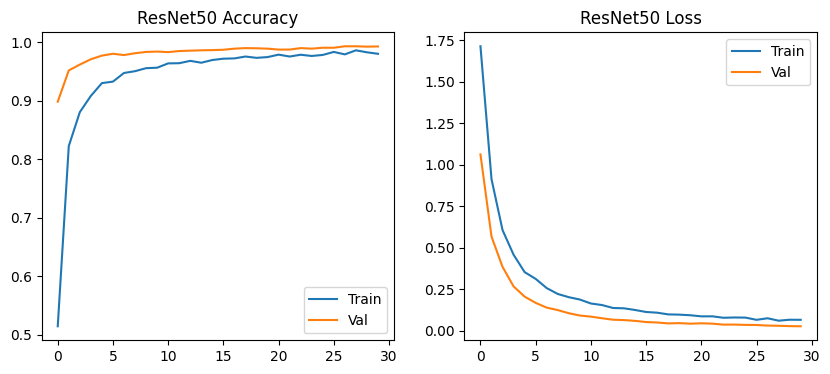

In [94]:
model_resnet50 = build_pretrained(models.resnet50, num_classes=len(train_dataset_pre.dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet50.parameters(), lr=1e-4)
train_and_evaluate(model_resnet50, train_loader_pre, test_loader_pre, criterion, optimizer, "ResNet50")

c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/30
--------------------
Train Loss: 1.6278 Acc: 0.5372
Val Loss: 0.9655 Acc: 0.9399
💾 Best model saved as MobileNetV2_best.pkl (Acc: 0.9399)

Epoch 2/30
--------------------
Train Loss: 0.8309 Acc: 0.8331
Val Loss: 0.5000 Acc: 0.9690
💾 Best model saved as MobileNetV2_best.pkl (Acc: 0.9690)

Epoch 3/30
--------------------
Train Loss: 0.5345 Acc: 0.9009
Val Loss: 0.3105 Acc: 0.9759
💾 Best model saved as MobileNetV2_best.pkl (Acc: 0.9759)

Epoch 4/30
--------------------
Train Loss: 0.3822 Acc: 0.9277
Val Loss: 0.2255 Acc: 0.9797
💾 Best model saved as MobileNetV2_best.pkl (Acc: 0.9797)

Epoch 5/30
--------------------
Train Loss: 0.3070 Acc: 0.9436
Val Loss: 0.1701 Acc: 0.9840
💾 Best model saved as MobileNetV2_best.pkl (Acc: 0.9840)

Epoch 6/30
--------------------
Train Loss: 0.2593 Acc: 0.9447
Val Loss: 0.1419 Acc: 0.9834

Epoch 7/30
--------------------
Train Loss: 0.2193 Acc: 0.9537
Val Loss: 0.1136 Acc: 0.9859
💾 Best model saved as MobileNetV2_best.pkl (Acc: 0.9859)

Epoch 

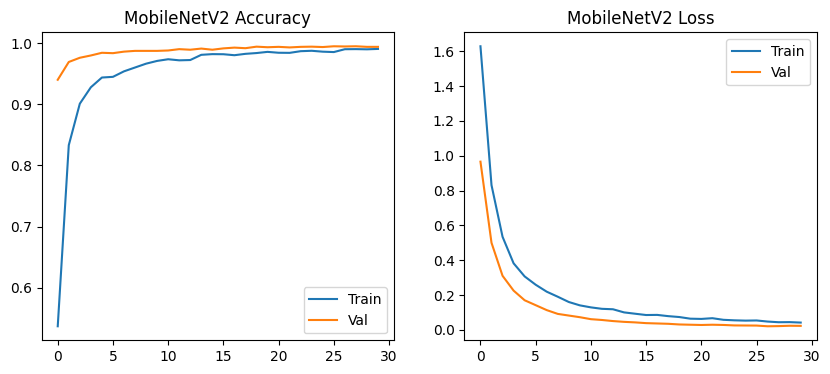

In [62]:
model_mobilenetv2 = build_pretrained(models.mobilenet_v2, num_classes=len(train_dataset_pre.dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mobilenetv2.parameters(), lr=1e-4)
train_and_evaluate(model_mobilenetv2, train_loader_pre, test_loader_pre, criterion, optimizer, "MobileNetV2")


Epoch 1/30
--------------------
Train Loss: 0.3307 Acc: 0.9303
Val Loss: 0.0216 Acc: 0.9953
💾 Best model saved as InceptionV3_best.pkl (Acc: 0.9953)

Epoch 2/30
--------------------
Train Loss: 0.0309 Acc: 0.9945
Val Loss: 0.0151 Acc: 0.9966
💾 Best model saved as InceptionV3_best.pkl (Acc: 0.9966)

Epoch 3/30
--------------------
Train Loss: 0.0180 Acc: 0.9963
Val Loss: 0.0097 Acc: 0.9972
💾 Best model saved as InceptionV3_best.pkl (Acc: 0.9972)

Epoch 4/30
--------------------
Train Loss: 0.0230 Acc: 0.9944
Val Loss: 0.0113 Acc: 0.9978
💾 Best model saved as InceptionV3_best.pkl (Acc: 0.9978)

Epoch 5/30
--------------------
Train Loss: 0.0160 Acc: 0.9968
Val Loss: 0.0108 Acc: 0.9984
💾 Best model saved as InceptionV3_best.pkl (Acc: 0.9984)

Epoch 6/30
--------------------
Train Loss: 0.0053 Acc: 0.9992
Val Loss: 0.0296 Acc: 0.9947

Epoch 7/30
--------------------
Train Loss: 0.0027 Acc: 0.9997
Val Loss: 0.0149 Acc: 0.9972

Epoch 8/30
--------------------
Train Loss: 0.0033 Acc: 0.9994


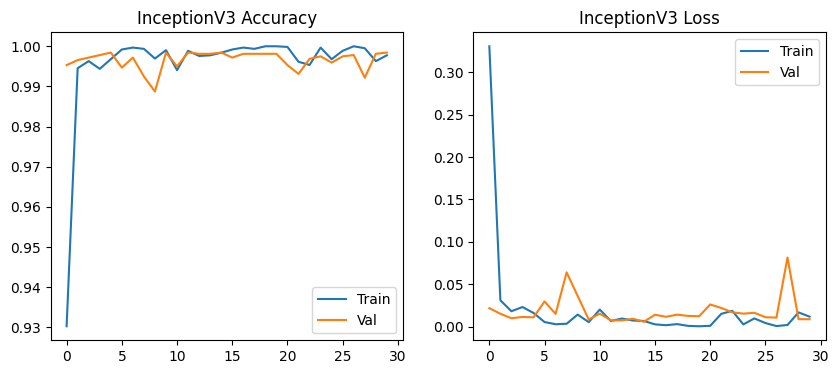

In [102]:
# InceptionV3 special case
model_inceptionv3 = models.inception_v3(pretrained=True, aux_logits=True)
criterion = nn.CrossEntropyLoss()
in_features = model_inceptionv3.fc.in_features
model_inceptionv3.fc = nn.Linear(in_features, len(train_dataset_incep.classes))
model_inceptionv3 = model_inceptionv3.to(DEVICE)
optimizer = optim.Adam(model_inceptionv3.parameters(), lr=1e-4)
train_and_evaluate(model_inceptionv3, train_loader_incep, test_loader_incep, criterion, optimizer, "InceptionV3")

c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\workstation\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\workstation/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:09<00:00, 2.32MB/s]



Epoch 1/30
--------------------
Train Loss: 1.8245 Acc: 0.5987
Val Loss: 1.1440 Acc: 0.9359
💾 Best model saved as EfficientNetB0_best.pkl (Acc: 0.9359)

Epoch 2/30
--------------------
Train Loss: 0.9372 Acc: 0.8586
Val Loss: 0.5627 Acc: 0.9631
💾 Best model saved as EfficientNetB0_best.pkl (Acc: 0.9631)

Epoch 3/30
--------------------
Train Loss: 0.5840 Acc: 0.9089
Val Loss: 0.3379 Acc: 0.9737
💾 Best model saved as EfficientNetB0_best.pkl (Acc: 0.9737)

Epoch 4/30
--------------------
Train Loss: 0.4280 Acc: 0.9272
Val Loss: 0.2467 Acc: 0.9797
💾 Best model saved as EfficientNetB0_best.pkl (Acc: 0.9797)

Epoch 5/30
--------------------
Train Loss: 0.3291 Acc: 0.9433
Val Loss: 0.1840 Acc: 0.9828
💾 Best model saved as EfficientNetB0_best.pkl (Acc: 0.9828)

Epoch 6/30
--------------------
Train Loss: 0.2715 Acc: 0.9534
Val Loss: 0.1497 Acc: 0.9837
💾 Best model saved as EfficientNetB0_best.pkl (Acc: 0.9837)

Epoch 7/30
--------------------
Train Loss: 0.2339 Acc: 0.9541
Val Loss: 0.1263 A

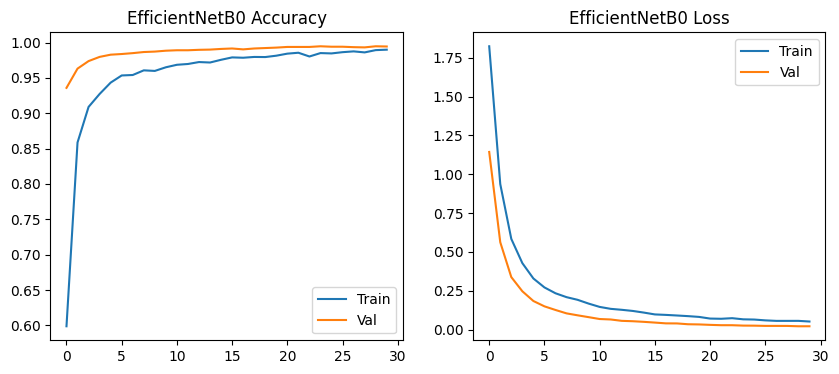

In [66]:
model_efficientnetb0 = build_pretrained(models.efficientnet_b0, num_classes=len(train_dataset_pre.dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnetb0.parameters(), lr=1e-4)
train_and_evaluate(model_efficientnetb0, train_loader_pre, test_loader_pre, criterion, optimizer, "EfficientNetB0")